# A note to the TA:

We implemented everything required for the assignment.

Due to hardware limitation issues, we were unable to train and get results on more than 5000 data points, which even causes some trouble training since BERT is a very big network.

Thus our results were affected a bit. We hope this doesn't affect our grade. We hope the grade of the assignment is per the work implemented and the resulting numbers of training.

Thanks a lot for understanding :)

# 1. Defining SBERT

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertConfig, BertTokenizer
from scipy import spatial


class SBERT(nn.Module):
    def __init__(self):
        super(SBERT, self).__init__()
        
        # self.model = BertModel.from_pretrained("bert-base-uncased")
        configuration = BertConfig()
        self.model = BertModel(configuration)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        self.pooling = nn.AvgPool1d(kernel_size=3,stride=1)
        # 768 / 3 -> 256
        self.linear = nn.Linear(in_features=2298, out_features=3) # 2298=(768-2)*3; 153 is the embedding dimension after pooling and stuff..
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sent1, sent2=None, objective="embedding"):
        encoded_input1 = self.tokenizer(sent1, padding=True, truncation=True, return_tensors='pt')
        output1 = self.model(**encoded_input1)
        output1 = self.pooling(output1["pooler_output"])
        
        if objective=="embedding":
            return output1

        encoded_input2 = self.tokenizer(sent2, padding=True, truncation=True, return_tensors='pt')
        output2 = self.model(**encoded_input2)
        output2 = self.pooling(output2["pooler_output"])
                        
        if objective == "regression":
            return torch.cosine_similarity(output1, output2)

        if objective == "classification":
            diff = abs(torch.subtract(output1,output2))
            concat = torch.cat([output1,output2,diff],axis=1)            
            result = self.linear(concat)
            out = self.softmax(result)
            return out

sbert = SBERT()

In [4]:
# sbert

# 2. Implement Regression Objective and Evaluate on STS

In [5]:
import pandas as pd

df_test = pd.read_csv("datasets/Stsbenchmark/sts-test.csv",header=0,names=["main-caption","genre","filename","year","score","sentence1","sentence2"])#,usecols=['score','sentence1','sentence2'])

df_test = df_test[['score','sentence1','sentence2']]
df_test.head()

,score,sentence1,sentence2
0,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
1,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
2,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
3,1.5,A man is playing a harp.,A man is playing a keyboard.
4,1.8,A woman is cutting onions.,A woman is cutting tofu.


In [7]:
ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
print("The min and max of the scores is:",(minn,maxx))

The min and max of the scores is: (0.0, 5.0)


In [8]:
def map_score(value, leftMin=0, leftMax=5, rightMin=-1, rightMax=1):
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin
    valueScaled = float(value - leftMin) / float(leftSpan)
    return rightMin + (valueScaled * rightSpan)

df_test['score'] = df_test['score'].apply(map_score)

In [10]:
ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
print("After mapping the values the range of scores is:",(minn,maxx))

After mapping the values the range of scores is: (-1.0, 1.0)


In [12]:
print("The nulls:")
df_test.isna().sum()

The nulls:


score        0
sentence1    0
sentence2    5
dtype: int64

In [13]:
df_test.dropna(inplace=True)
df_test.reset_index(inplace=True)

In [14]:
print("The nulls after dropping:")
df_test.isna().sum()

The nulls after dropping:


index        0
score        0
sentence1    0
sentence2    0
dtype: int64

In [15]:
sbert.eval()

cosine_scores = []
for i,row in df_test.iterrows():
    print(f"Finished {i}/{len(df_test)}",end="\r")
    score = sbert(row.sentence1,row.sentence2,"regression").detach().numpy()[0]
    cosine_scores.append(score)

In [19]:
from scipy.stats import spearmanr

spearmanr(df_test.score.values.tolist(),cosine_scores)

SpearmanrResult(correlation=0.29374685036801934, pvalue=7.398166147771895e-21)

# 3. Implement Classification Objective and Train a model

In [20]:
import json
json_list_train = list(open("datasets/snli_1.0/snli_1.0_train.jsonl","r"))
json_list_val = list(open("datasets/snli_1.0/snli_1.0_dev.jsonl","r"))

label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}

In [21]:
import pandas as pd

data_train = {'sentence1': [], 'sentence2': [], 'gold_label': []}
for json_str in json_list_train:
    try:
        result = json.loads(json_str)
        result['gold_label']=label2int[result['gold_label']]
        for key in data_train:
            data_train[key].append(result[key])
    except:
        pass
df_train = pd.DataFrame.from_dict(data_train)#.head()

data_val = {'sentence1': [], 'sentence2': [], 'gold_label': []}
for json_str in json_list_val:
    try:
        result = json.loads(json_str)
        result['gold_label']=label2int[result['gold_label']]
        for key in data_val:
            data_val[key].append(result[key])
    except:
        pass
df_val = pd.DataFrame.from_dict(data_val)#.head()

print("Training data:",len(df_train))
print("Testing data:",len(df_val))

Training data: 549367
Testing data: 9842


In [22]:
df_train.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,2
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
3,Children smiling and waving at camera,They are smiling at their parents,2
4,Children smiling and waving at camera,There are children present,1


In [23]:
from torch.utils.data import Dataset,DataLoader

class SNLI_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sent1 = row['sentence1']
        sent2 = row['sentence2']
        label = row['gold_label']
        return (sent1, sent2), label

- outputs of shape (N,C) where N is the batch size C is the number of classes
- target of shape (N)

In [ ]:
import torch.optim as optim
import time

# from torchsample.callbacks import EarlyStopping
# callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# model.set_callbacks(callbacks)


n_epochs = 10
n_batch = 16
lr=0.001


training_data = SNLI_Dataset(df_train)
train_dataloader = DataLoader(training_data, batch_size=n_batch, shuffle=False)

validation_data = SNLI_Dataset(df_val)
val_dataloader = DataLoader(validation_data, batch_size=n_batch, shuffle=True)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(sbert.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(sbert.parameters(), lr=lr)

sbert.train()
train_losses = []
val_losses = []
for epoch in range(n_epochs):

    for i,((sent1,sent2),label) in enumerate(train_dataloader):
        
        start = time.time()
        
        optimizer.zero_grad()
        
        output = sbert(sent1,sent2,objective="classification")
        loss = criterion(output, label)
        train_losses.append(loss)
        
#         (sent1_val,sent2_val),label_val = next(iter(val_dataloader))
#         output_val = sbert(sent1_val,sent2_val,"classification")
#         val_loss = criterion(output_val,label_val)
#         val_losses.append(val_loss)

        message = "epoch={}/{} iteration={}/{} train_loss={:.4f} took {:.4f} secs" \
            .format(epoch+1,n_epochs,i+1,len(train_dataloader),loss.detach().numpy(),time.time()-start)

        print(message)

        loss.backward()
        optimizer.step()

    PATH = f"models/classification_regression_epoch_{epoch+1}.pt"
    torch.save(sbert.state_dict(), PATH)

print('Finished Training')

epoch=1/10 iteration=1/34336 train_loss=1.1059 took 0.7070 secs
epoch=1/10 iteration=2/34336 train_loss=1.1709 took 0.4261 secs
epoch=1/10 iteration=3/34336 train_loss=1.1881 took 0.3999 secs
epoch=1/10 iteration=4/34336 train_loss=1.1084 took 0.4236 secs
epoch=1/10 iteration=5/34336 train_loss=1.1597 took 0.6614 secs
epoch=1/10 iteration=6/34336 train_loss=1.1511 took 0.7325 secs
epoch=1/10 iteration=7/34336 train_loss=1.2218 took 0.5861 secs
epoch=1/10 iteration=8/34336 train_loss=1.1032 took 0.3301 secs
epoch=1/10 iteration=9/34336 train_loss=1.1626 took 0.4545 secs
epoch=1/10 iteration=10/34336 train_loss=1.1426 took 0.3818 secs
epoch=1/10 iteration=11/34336 train_loss=1.1036 took 0.3551 secs
epoch=1/10 iteration=12/34336 train_loss=1.1771 took 0.3191 secs
epoch=1/10 iteration=13/34336 train_loss=1.1839 took 0.3191 secs
epoch=1/10 iteration=14/34336 train_loss=1.1054 took 0.4677 secs
epoch=1/10 iteration=15/34336 train_loss=1.1008 took 0.4597 secs
epoch=1/10 iteration=16/34336 trai

epoch=1/10 iteration=127/34336 train_loss=1.0977 took 0.3690 secs
epoch=1/10 iteration=128/34336 train_loss=1.1001 took 0.3332 secs
epoch=1/10 iteration=129/34336 train_loss=1.1000 took 0.3713 secs
epoch=1/10 iteration=130/34336 train_loss=1.1171 took 0.4331 secs
epoch=1/10 iteration=131/34336 train_loss=1.1060 took 0.3523 secs
epoch=1/10 iteration=132/34336 train_loss=1.0820 took 0.3680 secs
epoch=1/10 iteration=133/34336 train_loss=1.1085 took 0.3665 secs
epoch=1/10 iteration=134/34336 train_loss=1.0986 took 0.4781 secs
epoch=1/10 iteration=135/34336 train_loss=1.1000 took 0.4283 secs
epoch=1/10 iteration=136/34336 train_loss=1.1067 took 0.3226 secs
epoch=1/10 iteration=137/34336 train_loss=1.1103 took 0.3258 secs
epoch=1/10 iteration=138/34336 train_loss=1.0962 took 0.4284 secs
epoch=1/10 iteration=139/34336 train_loss=1.1038 took 0.3075 secs
epoch=1/10 iteration=140/34336 train_loss=1.0924 took 0.5742 secs
epoch=1/10 iteration=141/34336 train_loss=1.0968 took 0.3720 secs
epoch=1/10

epoch=1/10 iteration=252/34336 train_loss=1.0936 took 0.3439 secs
epoch=1/10 iteration=253/34336 train_loss=1.1012 took 0.3577 secs
epoch=1/10 iteration=254/34336 train_loss=1.0926 took 0.3493 secs
epoch=1/10 iteration=255/34336 train_loss=1.1052 took 0.4273 secs
epoch=1/10 iteration=256/34336 train_loss=1.1002 took 0.4254 secs
epoch=1/10 iteration=257/34336 train_loss=1.1050 took 0.5002 secs
epoch=1/10 iteration=258/34336 train_loss=1.0996 took 0.5125 secs
epoch=1/10 iteration=259/34336 train_loss=1.0950 took 0.4493 secs
epoch=1/10 iteration=260/34336 train_loss=1.1405 took 0.4415 secs
epoch=1/10 iteration=261/34336 train_loss=1.0980 took 0.4050 secs
epoch=1/10 iteration=262/34336 train_loss=1.0996 took 0.4618 secs
epoch=1/10 iteration=263/34336 train_loss=1.1056 took 0.4704 secs
epoch=1/10 iteration=264/34336 train_loss=1.0934 took 0.3020 secs
epoch=1/10 iteration=265/34336 train_loss=1.0994 took 0.4040 secs
epoch=1/10 iteration=266/34336 train_loss=1.0997 took 0.3608 secs
epoch=1/10

epoch=1/10 iteration=377/34336 train_loss=1.1098 took 0.4717 secs
epoch=1/10 iteration=378/34336 train_loss=1.0992 took 0.3339 secs
epoch=1/10 iteration=379/34336 train_loss=1.1069 took 0.4697 secs
epoch=1/10 iteration=380/34336 train_loss=1.0999 took 0.3949 secs
epoch=1/10 iteration=381/34336 train_loss=1.0997 took 0.3452 secs
epoch=1/10 iteration=382/34336 train_loss=1.0939 took 0.3781 secs
epoch=1/10 iteration=383/34336 train_loss=1.1031 took 0.3377 secs
epoch=1/10 iteration=384/34336 train_loss=1.1020 took 0.3799 secs
epoch=1/10 iteration=385/34336 train_loss=1.1027 took 0.2858 secs
epoch=1/10 iteration=386/34336 train_loss=1.1038 took 0.3774 secs
epoch=1/10 iteration=387/34336 train_loss=1.1078 took 0.3635 secs
epoch=1/10 iteration=388/34336 train_loss=1.0969 took 0.3824 secs
epoch=1/10 iteration=389/34336 train_loss=1.1022 took 0.4305 secs
epoch=1/10 iteration=390/34336 train_loss=1.1000 took 0.5288 secs
epoch=1/10 iteration=391/34336 train_loss=1.1014 took 0.4507 secs
epoch=1/10

epoch=1/10 iteration=502/34336 train_loss=1.1015 took 0.3570 secs
epoch=1/10 iteration=503/34336 train_loss=1.1027 took 0.3654 secs
epoch=1/10 iteration=504/34336 train_loss=1.0992 took 0.3958 secs
epoch=1/10 iteration=505/34336 train_loss=1.1005 took 0.5075 secs
epoch=1/10 iteration=506/34336 train_loss=1.0999 took 0.4457 secs
epoch=1/10 iteration=507/34336 train_loss=1.1068 took 0.4602 secs
epoch=1/10 iteration=508/34336 train_loss=1.1041 took 0.3417 secs
epoch=1/10 iteration=509/34336 train_loss=1.0911 took 0.5211 secs
epoch=1/10 iteration=510/34336 train_loss=1.1035 took 0.3986 secs
epoch=1/10 iteration=511/34336 train_loss=1.1097 took 0.3953 secs
epoch=1/10 iteration=512/34336 train_loss=1.0980 took 0.3953 secs
epoch=1/10 iteration=513/34336 train_loss=1.0989 took 0.3885 secs
epoch=1/10 iteration=514/34336 train_loss=1.1009 took 0.4470 secs
epoch=1/10 iteration=515/34336 train_loss=1.1113 took 0.4314 secs
epoch=1/10 iteration=516/34336 train_loss=1.0976 took 0.4414 secs
epoch=1/10

epoch=1/10 iteration=627/34336 train_loss=1.1021 took 0.3714 secs
epoch=1/10 iteration=628/34336 train_loss=1.0923 took 0.3818 secs
epoch=1/10 iteration=629/34336 train_loss=1.1048 took 0.3221 secs
epoch=1/10 iteration=630/34336 train_loss=1.1056 took 0.3449 secs
epoch=1/10 iteration=631/34336 train_loss=1.1040 took 0.3434 secs
epoch=1/10 iteration=632/34336 train_loss=1.1053 took 0.3193 secs
epoch=1/10 iteration=633/34336 train_loss=1.0978 took 0.4865 secs
epoch=1/10 iteration=634/34336 train_loss=1.0998 took 0.5117 secs
epoch=1/10 iteration=635/34336 train_loss=1.0987 took 0.6334 secs
epoch=1/10 iteration=636/34336 train_loss=1.0984 took 0.4702 secs
epoch=1/10 iteration=637/34336 train_loss=1.1033 took 0.4426 secs
epoch=1/10 iteration=638/34336 train_loss=1.0990 took 0.4426 secs
epoch=1/10 iteration=639/34336 train_loss=1.0990 took 0.4420 secs
epoch=1/10 iteration=640/34336 train_loss=1.0969 took 0.3982 secs
epoch=1/10 iteration=641/34336 train_loss=1.1014 took 0.4450 secs
epoch=1/10

epoch=1/10 iteration=752/34336 train_loss=1.1046 took 0.4105 secs
epoch=1/10 iteration=753/34336 train_loss=1.1029 took 0.3185 secs
epoch=1/10 iteration=754/34336 train_loss=1.0971 took 0.3870 secs
epoch=1/10 iteration=755/34336 train_loss=1.0991 took 0.4435 secs
epoch=1/10 iteration=756/34336 train_loss=1.0963 took 0.4850 secs
epoch=1/10 iteration=757/34336 train_loss=1.0956 took 0.4180 secs
epoch=1/10 iteration=758/34336 train_loss=1.1058 took 0.6471 secs
epoch=1/10 iteration=759/34336 train_loss=1.1098 took 0.4610 secs
epoch=1/10 iteration=760/34336 train_loss=1.0951 took 0.4518 secs
epoch=1/10 iteration=761/34336 train_loss=1.1016 took 0.3948 secs
epoch=1/10 iteration=762/34336 train_loss=1.1044 took 0.4513 secs
epoch=1/10 iteration=763/34336 train_loss=1.1009 took 0.3583 secs
epoch=1/10 iteration=764/34336 train_loss=1.1001 took 0.3250 secs
epoch=1/10 iteration=765/34336 train_loss=1.1039 took 0.4266 secs
epoch=1/10 iteration=766/34336 train_loss=1.1027 took 0.3304 secs
epoch=1/10

In [24]:
PATH = "models/classification_epoch_5.pt"

sbert = SBERT()
sbert.load_state_dict(torch.load(PATH))
# sbert.train()

<All keys matched successfully>

In [34]:
# res = []
# for idx in range(5):
#     pred = torch.argmax(sbert(df_train.iloc[idx].sentence1,df_train.iloc[idx].sentence2,"classification")).numpy().item()
#     true = df_train.iloc[idx]['gold_label']
#     print(pred==true)
#     res.append(pred==true)
# acc = sum(res)/len(res)
# print(acc)

In [33]:
sbert.eval()
res = []
# for idx in range(5):
for i, row in df_train.head(5000).iterrows():
    pred = torch.argmax(sbert(row.sentence1,row.sentence2,"classification")).numpy().item()
    true = row['gold_label']
    res.append(pred==true)
    print(f"Finished {i}/{len(df_train.head(5000))} got {sum(res)}/{len(res)}",end="\r")
acc = sum(res)/len(res)
print()
print(acc)

0.3338ed 4999/5000 got 1669/5000


# 4. Use the model trained for classification and fine-tuning it using the regression objective

In [36]:
PATH = "models/classification_epoch_5.pt"

sbert = SBERT()
sbert.load_state_dict(torch.load(PATH))
# sbert.train()

<All keys matched successfully>

In [37]:
import pandas as pd

df_train = pd.read_csv("datasets/Stsbenchmark/sts-train.csv",header=0,names=["main-caption","genre","filename","year","score","sentence1","sentence2"])#,usecols=['score','sentence1','sentence2'])
df_test = pd.read_csv("datasets/Stsbenchmark/sts-test.csv",header=0,names=["main-caption","genre","filename","year","score","sentence1","sentence2"])#,usecols=['score','sentence1','sentence2'])

df_train = df_train[['score','sentence1','sentence2']]
df_test = df_test[['score','sentence1','sentence2']]

df_train.head()
# df_test.head()

,score,sentence1,sentence2
0,3.80,A man is playing a large flute.,A man is playing a flute.
1,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
2,2.60,Three men are playing chess.,Two men are playing chess.
3,4.25,A man is playing the cello.,A man seated is playing the cello.
4,4.25,Some men are fighting.,Two men are fighting.


In [38]:
print(df_train.isna().sum())
print()
print(df_test.isna().sum())

score         0
sentence1     0
sentence2    11
dtype: int64

score        0
sentence1    0
sentence2    5
dtype: int64


In [39]:
df_train.dropna(inplace=True)
df_train.reset_index(inplace=True)

df_test.dropna(inplace=True)
df_test.reset_index(inplace=True)

In [40]:
print(df_train.isna().sum())
print()
print(df_test.isna().sum())

index        0
score        0
sentence1    0
sentence2    0
dtype: int64

index        0
score        0
sentence1    0
sentence2    0
dtype: int64


In [41]:
ls = list(df_train.score)
minn = min(ls)
maxx = max(ls)
(minn,maxx)

(0.0, 5.0)

In [42]:
def map_score(value, leftMin=0, leftMax=5, rightMin=-1, rightMax=1):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

df_train['score'] = df_train['score'].apply(map_score)
df_test['score'] = df_test['score'].apply(map_score)

In [43]:
ls = list(df_train.score)
minn = min(ls)
maxx = max(ls)
(minn,maxx)

(-1.0, 1.0)

In [44]:
df_train.sentence1 = df_train.sentence1.astype(str)
df_train.sentence2 = df_train.sentence2.astype(str)

df_test.sentence1 = df_test.sentence1.astype(str)
df_test.sentence2 = df_test.sentence2.astype(str)

In [45]:
df_train = df_train[~df_train.sentence1.str.contains("\n")]
df_train = df_train[~df_train.sentence2.str.contains("\n")]

df_test = df_test[~df_test.sentence1.str.contains("\n")]
df_test = df_test[~df_test.sentence2.str.contains("\n")]

In [46]:
from torch.utils.data import Dataset,DataLoader

class STS_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sent1 = row['sentence1']
        sent2 = row['sentence2']
        label = row['score']
        return (sent1, sent2), label

In [47]:
sbert("I love pizza","I love burger",objective="regression")

tensor([0.9932], grad_fn=<DivBackward0>)

In [48]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(sbert.parameters(), lr=0.001, momentum=0.9)

In [49]:
training_data_regression = STS_Dataset(df_train)
train_dataloader_regression = DataLoader(training_data_regression, batch_size=16, shuffle=False)

In [19]:
import time

losses = []
for epoch in range(n_epochs):

    for i,((sent1,sent2),label) in enumerate(train_dataloader_regression):
        start = time.time()

        output = sbert(sent1,sent2,objective="regression")
        optimizer.zero_grad()

        label = label.float()
        loss = criterion(output, label)

        losses.append(loss)

        print(f"epoch={epoch+1}/{n_epochs} iteration={i+1}/{len(train_dataloader_regression)} loss={loss.detach().numpy()} took {time.time()-start} secs")

        loss.backward()
        optimizer.step()
    
    PATH = f"models/classification_regression_epoch_{epoch+1}.pt"
    torch.save(sbert.state_dict(), PATH)

print('Finished Training')

epoch=3/3 iteration=1/245 loss=0.6318621635437012 took 0.3605921268463135 secs
epoch=3/3 iteration=2/245 loss=0.40562236309051514 took 0.31027746200561523 secs
epoch=3/3 iteration=3/245 loss=0.8065990209579468 took 0.23789548873901367 secs
epoch=3/3 iteration=4/245 loss=0.6440738439559937 took 0.2286243438720703 secs
epoch=3/3 iteration=5/245 loss=0.7480531930923462 took 0.22533774375915527 secs
epoch=3/3 iteration=6/245 loss=1.1598297357559204 took 0.23276448249816895 secs
epoch=3/3 iteration=7/245 loss=0.6883032917976379 took 0.20563983917236328 secs
epoch=3/3 iteration=8/245 loss=1.2146214246749878 took 0.23572778701782227 secs
epoch=3/3 iteration=9/245 loss=1.1725239753723145 took 0.3171517848968506 secs
epoch=3/3 iteration=10/245 loss=0.4181896448135376 took 0.31582069396972656 secs
epoch=3/3 iteration=11/245 loss=1.568471908569336 took 0.2533571720123291 secs
epoch=3/3 iteration=12/245 loss=0.963043749332428 took 0.33654332160949707 secs
epoch=3/3 iteration=13/245 loss=1.31764042

epoch=3/3 iteration=104/245 loss=1.8507169485092163 took 0.40380382537841797 secs
epoch=3/3 iteration=105/245 loss=0.5341312289237976 took 0.281658411026001 secs
epoch=3/3 iteration=106/245 loss=1.7584996223449707 took 0.39264345169067383 secs
epoch=3/3 iteration=107/245 loss=1.7386915683746338 took 0.3236367702484131 secs
epoch=3/3 iteration=108/245 loss=1.4523295164108276 took 0.46636152267456055 secs
epoch=3/3 iteration=109/245 loss=1.3675284385681152 took 0.3431675434112549 secs
epoch=3/3 iteration=110/245 loss=1.5072845220565796 took 0.46570897102355957 secs
epoch=3/3 iteration=111/245 loss=1.477246642112732 took 0.3639953136444092 secs
epoch=3/3 iteration=112/245 loss=1.9153281450271606 took 0.496049165725708 secs
epoch=3/3 iteration=113/245 loss=1.9780460596084595 took 0.40122342109680176 secs
epoch=3/3 iteration=114/245 loss=0.8913781642913818 took 0.362440824508667 secs
epoch=3/3 iteration=115/245 loss=1.189072847366333 took 0.38720059394836426 secs
epoch=3/3 iteration=116/245

epoch=3/3 iteration=205/245 loss=1.8633840084075928 took 0.2967853546142578 secs
epoch=3/3 iteration=206/245 loss=1.663746953010559 took 0.391430139541626 secs
epoch=3/3 iteration=207/245 loss=1.3507640361785889 took 0.29930734634399414 secs
epoch=3/3 iteration=208/245 loss=1.3213552236557007 took 0.27230000495910645 secs
epoch=3/3 iteration=209/245 loss=1.6973134279251099 took 0.40332984924316406 secs
epoch=3/3 iteration=210/245 loss=1.343172311782837 took 0.37693357467651367 secs
epoch=3/3 iteration=211/245 loss=0.8760389089584351 took 0.5765392780303955 secs
epoch=3/3 iteration=212/245 loss=1.4025315046310425 took 0.2912123203277588 secs
epoch=3/3 iteration=213/245 loss=1.35648512840271 took 0.309220552444458 secs
epoch=3/3 iteration=214/245 loss=1.7692828178405762 took 0.33842039108276367 secs
epoch=3/3 iteration=215/245 loss=0.8352620601654053 took 0.3434717655181885 secs
epoch=3/3 iteration=216/245 loss=1.2677700519561768 took 0.2976102828979492 secs
epoch=3/3 iteration=217/245 l

epoch=4/3 iteration=62/245 loss=2.460096597671509 took 0.34749388694763184 secs
epoch=4/3 iteration=63/245 loss=1.619706392288208 took 0.39972615242004395 secs
epoch=4/3 iteration=64/245 loss=1.4590446949005127 took 0.5216257572174072 secs
epoch=4/3 iteration=65/245 loss=1.2528035640716553 took 0.33443593978881836 secs
epoch=4/3 iteration=66/245 loss=1.5406498908996582 took 0.41724061965942383 secs
epoch=4/3 iteration=67/245 loss=0.9954672455787659 took 0.356950044631958 secs
epoch=4/3 iteration=68/245 loss=1.2097232341766357 took 0.3294053077697754 secs
epoch=4/3 iteration=69/245 loss=1.3291305303573608 took 0.39972782135009766 secs
epoch=4/3 iteration=70/245 loss=1.4150139093399048 took 0.36209535598754883 secs
epoch=4/3 iteration=71/245 loss=1.2583255767822266 took 0.35492801666259766 secs
epoch=4/3 iteration=72/245 loss=2.0546653270721436 took 0.3408234119415283 secs
epoch=4/3 iteration=73/245 loss=1.1334202289581299 took 0.3529696464538574 secs
epoch=4/3 iteration=74/245 loss=1.24

epoch=4/3 iteration=164/245 loss=1.4023500680923462 took 0.36707353591918945 secs
epoch=4/3 iteration=165/245 loss=1.1764236688613892 took 0.6982388496398926 secs
epoch=4/3 iteration=166/245 loss=0.6691382527351379 took 0.3607752323150635 secs
epoch=4/3 iteration=167/245 loss=1.1201788187026978 took 0.2885754108428955 secs
epoch=4/3 iteration=168/245 loss=1.1639530658721924 took 0.38405919075012207 secs
epoch=4/3 iteration=169/245 loss=0.6361140608787537 took 0.31299757957458496 secs
epoch=4/3 iteration=170/245 loss=0.982347846031189 took 0.29977965354919434 secs
epoch=4/3 iteration=171/245 loss=1.0384398698806763 took 0.33462071418762207 secs
epoch=4/3 iteration=172/245 loss=1.1163216829299927 took 0.3148176670074463 secs
epoch=4/3 iteration=173/245 loss=1.4589141607284546 took 0.3712575435638428 secs
epoch=4/3 iteration=174/245 loss=1.2983882427215576 took 0.2595553398132324 secs
epoch=4/3 iteration=175/245 loss=1.4543100595474243 took 0.2944362163543701 secs
epoch=4/3 iteration=176/

epoch=5/3 iteration=21/245 loss=2.4582080841064453 took 0.2923130989074707 secs
epoch=5/3 iteration=22/245 loss=1.9621002674102783 took 0.33000826835632324 secs
epoch=5/3 iteration=23/245 loss=2.7649903297424316 took 0.26053357124328613 secs
epoch=5/3 iteration=24/245 loss=1.5590500831604004 took 0.28804492950439453 secs
epoch=5/3 iteration=25/245 loss=1.9557619094848633 took 0.32326388359069824 secs
epoch=5/3 iteration=26/245 loss=1.951329231262207 took 0.3515346050262451 secs
epoch=5/3 iteration=27/245 loss=2.3096039295196533 took 0.3036689758300781 secs
epoch=5/3 iteration=28/245 loss=1.8527941703796387 took 0.3492581844329834 secs
epoch=5/3 iteration=29/245 loss=2.6459755897521973 took 0.29360508918762207 secs
epoch=5/3 iteration=30/245 loss=2.366961717605591 took 0.3466796875 secs
epoch=5/3 iteration=31/245 loss=2.1738088130950928 took 0.3424363136291504 secs
epoch=5/3 iteration=32/245 loss=0.5084947347640991 took 0.2595398426055908 secs
epoch=5/3 iteration=33/245 loss=0.663967490

epoch=5/3 iteration=123/245 loss=1.5662037134170532 took 0.34417176246643066 secs
epoch=5/3 iteration=124/245 loss=1.0649387836456299 took 0.37200236320495605 secs
epoch=5/3 iteration=125/245 loss=2.2273178100585938 took 0.36645030975341797 secs
epoch=5/3 iteration=126/245 loss=1.388604760169983 took 0.3906404972076416 secs
epoch=5/3 iteration=127/245 loss=1.405300498008728 took 0.47908449172973633 secs
epoch=5/3 iteration=128/245 loss=1.0094449520111084 took 0.39264798164367676 secs
epoch=5/3 iteration=129/245 loss=1.0041084289550781 took 0.34269070625305176 secs
epoch=5/3 iteration=130/245 loss=1.1191412210464478 took 0.4011244773864746 secs
epoch=5/3 iteration=131/245 loss=0.9417852759361267 took 0.33696508407592773 secs
epoch=5/3 iteration=132/245 loss=0.6198779344558716 took 0.35736656188964844 secs
epoch=5/3 iteration=133/245 loss=0.8394812345504761 took 0.44800877571105957 secs
epoch=5/3 iteration=134/245 loss=1.0861519575119019 took 0.36858177185058594 secs
epoch=5/3 iteration=

epoch=5/3 iteration=224/245 loss=1.8485153913497925 took 0.2998363971710205 secs
epoch=5/3 iteration=225/245 loss=1.6178762912750244 took 0.3291158676147461 secs
epoch=5/3 iteration=226/245 loss=0.9430502653121948 took 0.30178022384643555 secs
epoch=5/3 iteration=227/245 loss=0.9190624952316284 took 0.34763288497924805 secs
epoch=5/3 iteration=228/245 loss=1.5588866472244263 took 0.32901430130004883 secs
epoch=5/3 iteration=229/245 loss=1.666789174079895 took 0.3173096179962158 secs
epoch=5/3 iteration=230/245 loss=1.2276209592819214 took 0.4131588935852051 secs
epoch=5/3 iteration=231/245 loss=1.3496381044387817 took 0.32958030700683594 secs
epoch=5/3 iteration=232/245 loss=1.1364827156066895 took 0.2991793155670166 secs
epoch=5/3 iteration=233/245 loss=0.9926809668540955 took 0.314023494720459 secs
epoch=5/3 iteration=234/245 loss=0.14526158571243286 took 0.31540346145629883 secs
epoch=5/3 iteration=235/245 loss=0.2231157124042511 took 0.2711985111236572 secs
epoch=5/3 iteration=236/

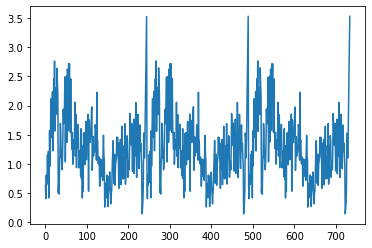

In [24]:
import matplotlib.pyplot as plt
train_losses = [l.detach().numpy() for l in losses]
plt.plot(train_losses)

# 5. Compare and evaluate the 2 new models on the STS benchmark

## a. first with pure classification objective:

In [52]:
PATH = "models/classification_epoch_5.pt"
sbert = SBERT()
sbert.load_state_dict(torch.load(PATH))
sbert.eval()

import pandas as pd
df_test = pd.read_csv("datasets/Stsbenchmark/sts-test.csv",header=0,names=["main-caption","genre","filename","year","score","sentence1","sentence2"])#,usecols=['score','sentence1','sentence2'])

df_test = df_test[['score','sentence1','sentence2']]
# df_test.head()

ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
# (minn,maxx)

def map_score(value, leftMin=0, leftMax=5, rightMin=-1, rightMax=1):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

df_test['score'] = df_test['score'].apply(map_score)

ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
# (minn,maxx)

# df_test.isna().sum()

df_test.dropna(inplace=True)
df_test.reset_index(inplace=True)

# df_test.isna().sum()

cosine_scores = []
for i,row in df_test.iterrows():
    print(f"Finished {i}/{len(df_test)}",end="\r")
    score = sbert(row.sentence1,row.sentence2,"regression").detach().numpy()[0]
    cosine_scores.append(score)

In [54]:
from scipy.stats import spearmanr

spearmanr(df_test.score.values.tolist(),cosine_scores)

SpearmanrResult(correlation=0.03714025583281556, pvalue=0.24661266975901172)

## b. second with classification-trained regression-fine-tuned objective:

In [50]:
PATH = "models/classification_regression_epoch_5.pt"
sbert = SBERT()
sbert.load_state_dict(torch.load(PATH))
sbert.eval()

import pandas as pd
df_test = pd.read_csv("datasets/Stsbenchmark/sts-test.csv",header=0,names=["main-caption","genre","filename","year","score","sentence1","sentence2"])#,usecols=['score','sentence1','sentence2'])

df_test = df_test[['score','sentence1','sentence2']]
# df_test.head()

ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
# (minn,maxx)

def map_score(value, leftMin=0, leftMax=5, rightMin=-1, rightMax=1):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

df_test['score'] = df_test['score'].apply(map_score)

ls = list(df_test.score)
minn = min(ls)
maxx = max(ls)
# (minn,maxx)

# df_test.isna().sum()

df_test.dropna(inplace=True)
df_test.reset_index(inplace=True)

# df_test.isna().sum()

cosine_scores = []
for i,row in df_test.iterrows():
    print(f"Finished {i}/{len(df_test)}",end="\r")
    score = sbert(row.sentence1,row.sentence2,"regression").detach().numpy()[0]
    cosine_scores.append(score)

In [51]:
labels = df_test.score.values.tolist()

from scipy.stats import spearmanr
spearmanr(labels,cosine_scores)

SpearmanrResult(correlation=0.02538929297721189, pvalue=0.42842418542383065)

# 6. Use your best fine-tuned model and create a small semantic search system

### We go for the first model a with ~slightly higher correlation

In [5]:
PATH = "models/classification_epoch_5.pt"
sbert = SBERT()
sbert.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
import json
list_ = []
path = "datasets/News_Category_Dataset_v2.json"
with open(path) as files:
    for file in files:
        list_.append(json.loads(file))

In [7]:
import pandas as pd

df_news = pd.DataFrame(list_)
df_news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [8]:
sent1 = list(df_news.headline)
print("Length before splitting:",len(sent1))
sent2 = [x for sentence in sent1 for x in sentence.split(".")]
sent2 = [x for x in sent2 if x]
print("Length after splitting:",len(sent2))
print(f"Data increased by {len(sent2)-len(sent1)} sentences")

Length before splitting: 200853
Length after splitting: 215043
Data increased by 14190 sentences


In [9]:
sent2 = sent2[:5000]

In [10]:
sent2[:5]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog']

In [11]:
input_sentence = "Sweden is a very safe place."

In [12]:
def create_embeddings(sentences):
    embeddings = []
    for i,sentence in enumerate(sentences):
        try:
            print(f"Finished iteration {i}/{len(sentences)}",end="\r")

            embeddings.append(sbert(sentence,objective="embedding"))
            
        except:
            pass
    
    embeddings = torch.cat(embeddings,0)
    
    embeddings = torch.FloatTensor(embeddings)
    torch.save(embeddings, 'datasets/embeddings.pt')

In [ ]:
create_embeddings(sent2[:5000])

In [13]:
embeddings = torch.load('datasets/embeddings.pt')
embeddings.shape

torch.Size([5000, 766])

In [27]:
def search_engine(input_sentence, embeddings_database="embeddings",K=5):
    embedding = sbert(input_sentence,"embedding")
    idx = torch.argsort(torch.cosine_similarity(embedding,embeddings),descending=True)[:5]
    return [sent2[i] for i in idx]

In [28]:
input_sentence = "I am the king of the jungle"
search_engine(input_sentence)

['White House Preps Spending Cuts Bill That Could Set Up Another Shutdown Standoff',
 'GOP Senator Reintroduces Bill To Protect Discrimination Against LGBTQ People',
 'Group Warns Hundreds Of School Districts They May Be Putting Student Lives In Danger',
 ' Embassy In Jerusalem Opens Its Doors As Protests Rage Nearby',
 "Steve Bannon Doesn't Deny Anything He Said In 'Fire And Fury'"]